# Proiect la disciplina SIAI (Sisteme Instruibile pentru Analiza Imaginilor)  

### Informatii generale

Pentru "Proiect cercetare 2", disciplina SIAI, fiecare student va avea un mic proiect! 
Proiectul implica proiectarea si testarea unor scenarii de ML (Machine Learning) si DL (Deep Learning) pentru clasificarea imaginilor cu o acuratete cat mai mare, in functie de problema de clasificare data.

Proiectul implica rularea unei aplicatii practice si realizarea unei prezentări PPT (pentru a avea informatia mai bine structurata), in care se trece prin fazele implicate intr-o schema de clasificare pentru rezolvarea unei probleme specifice - intelegere set date/ preprocesare/ creare model/ antrenare/ testare/ evaluare performante. 

Fiecare student va avea un clasificator clasic si o retea neuronala convolutionala, cu aplicare pe o baza de date specifica. 
Proiectul se va incarca online, pe Teams-ul disciplinei la assignment-ul create cu acest scop.

Setul de date se va incarca automat utilizand `tensorflow_datasets` (se pot vizualiza aici: https://www.tensorflow.org/datasets/catalog/beans).

Va stau la dispozitie pentru orice nelamurire pe chat-ul de la Teams! 

### Mod de lucru, proiectare si testare aplicatie practica

Se va lucra in mediul de programare Python, utilizand Google Colab pentru rulare.

In Google Colab recomand setarea modului de executie ca GPU (din meniul principal *Executie->Schimbati tipul executiei* se selecteaza GPU).

### Incarcarea setului de date

Fiecare student va utiliza o baza de date proprie pentru a testa o strategie de clasificare pentru rezolvarea unei probleme date. 

Exemplificarea din acest script se va realiaza pe setul de date MNIST, care contine cei 10 digiti, de la 0 la 9, scrisi de mana [lecun2010mnist]. 

In [41]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Crearea unui folder pentru incarcarea (temporar) a setului de date

!mkdir TmpPrSIAI # creare folder
cache_dir = 'TmpPrSIAI'; # definire variabila cu nume folder

# List all available datasets to see how the wikipedia dataset is called.
# tfds.list_builders()

mkdir: cannot create directory ‘TmpPrSIAI’: File exists


In [42]:
DATASET_NAME = 'mnist' # numele setului de date 

ds_builder = tfds.builder(DATASET_NAME, data_dir=cache_dir)
ds_builder.download_and_prepare()
print('-------------')
print(ds_builder.info)
print('-------------')
classes_num = ds_builder.info.features['label'].num_classes;
classes_names = ds_builder.info.features['label'].names; 

print('     - Numar clase: ', classes_num)
print('     - Clasele: ', classes_names)

# Incarcare date 
ds_upload = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))

(X, y) = (ds_upload['image'], ds_upload['label'])

#  Divizare dataset in - Training set / Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

print('     - x_train.shape', x_train.shape)
print('     - x_test.shape', x_test.shape)

-------------
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

-------------
     - Numar clase:  10
     - Clasele:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
     - x_train.shape (42000, 28, 28, 1)
     - x_test.shape (18000, 28, 28, 1)


 Labels,  10  classes:  [0 1 2 3 4 5 6 7 8 9]


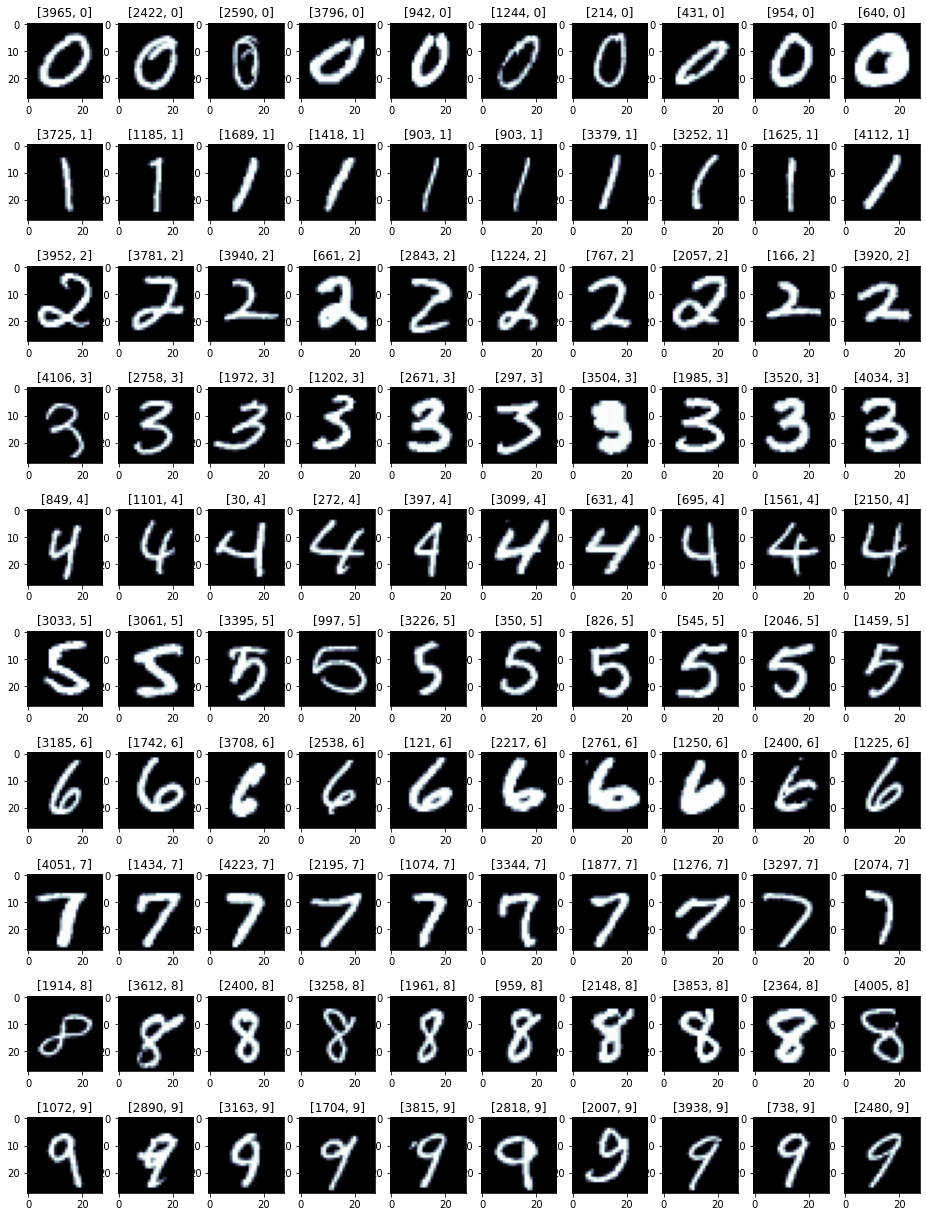

In [43]:
# incarcare fisiere .py locale
import UtilsPredictionResults as upr # trebuie incarcat din directorul cu date Proiect
import InitializeModelsCNN as iniCNN # trebuie incarcat din directorul cu date Proiect

import numpy as np
# Labels y_train/ y_test - numerical values 
y_label_names = np.unique(y_train)
nrCls = y_label_names.shape[0]

# Plot some images from DataSet
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# Plot some images from DataSet
if (x_train.shape[3] == 1): # imagini pe nivele de gri
  upr.ImageIllustrationOriginalDataSet(x_train[:,:,:,0], y_train, y_label_names)
else:
  upr.ImageIllustrationOriginalDataSet(x_train, y_train, y_label_names)

## CNN 

### Pre-procesarea datelor

In [44]:
# PreProcessing Data - X Data
# We should normalize the X data

x_train_p = x_train/255
x_test_p = x_test/255
print('Original images range: [', x_train[0].min(),',', x_train[0].max(),']')
print('PreProcessed images range: [',x_test_p[0].min(),',', x_test_p[0].max(),']')

# Reshaping the X Data
# Right now our data is 60,000 images stored in 28 by 28 pixel array formation. 
# 
# This is correct for a CNN, but we need to add one more dimension to show we're 
# dealing with 1 RGB channel (since technically the images are in black and white, 
# only showing values from 0-255 on a single channel), 
# an color image would have 3 dimensions.
if (x_train_p.shape==3):
  ch = 1
  [Im, Hm, Wm] = x_train_p.shape
  [It, Ht, Wt] = x_test_p.shape
else:
  [Im, Hm, Wm, ch] = x_train_p.shape
  [It, Ht, Wt, ch] = x_test_p.shape

# Reshape to include channel dimension (in this case, 1 channel)
x_train_p = x_train_p.reshape(Im, Hm, Wm, ch)
x_test_p = x_test_p.reshape(It, Ht, Wt,ch)

print('Reshaped datasets: ')
print('     - x_train_p.shape', x_train_p.shape)
print('     - x_test_p.shape', x_test_p.shape)

Original images range: [ 0 , 255 ]
PreProcessed images range: [ 0.0 , 1.0 ]
Reshaped datasets: 
     - x_train_p.shape (42000, 28, 28, 1)
     - x_test_p.shape (18000, 28, 28, 1)


In [45]:
# PreProcessing Data - labels y
# We first need to make sure the labels will be understandable by our CNN.

# Our labels are numbers - we need labels to be "one hot encoded" 
# Keras has an easy to use function for this: ...= to_categorical(...)

from keras.utils.np_utils import to_categorical
print(' Original shape of labels vector:')
print('     - y_train.shape', y_train.shape)

# "one hot encoded" labels
y_cat_train = to_categorical(y_train, nrCls)
y_cat_test = to_categorical(y_test, nrCls)
print(' One Hot Encoded, to_categorical, labels:')
print('     - y_cat_train.shape', y_cat_train.shape)
print('     - y_cat_train[0].shape', y_cat_train[0].shape)
print(' Before - y_train[0]: ', y_train[0], ', after  - y_cat_train[0]:', y_cat_train[0])
print(' Before - y_train[1]: ', y_train[1], ', after  - y_cat_train[1]:', y_cat_train[1])
print(' Before - y_train[2]: ', y_train[2], ', after  - y_cat_train[2]:', y_cat_train[2])
print(' Before - y_train[3]: ', y_train[3], ', after  - y_cat_train[3]:', y_cat_train[3])

 Original shape of labels vector:
     - y_train.shape (42000,)
 One Hot Encoded, to_categorical, labels:
     - y_cat_train.shape (42000, 10)
     - y_cat_train[0].shape (10,)
 Before - y_train[0]:  5 , after  - y_cat_train[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 Before - y_train[1]:  6 , after  - y_cat_train[1]: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 Before - y_train[2]:  9 , after  - y_cat_train[2]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 Before - y_train[3]:  1 , after  - y_cat_train[3]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [46]:
# initialize the optimizer and model
print("[INFO] compiling model...")
model = iniCNN.MiniVGGNet(Hm, Wm, ch, nrCls)
# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# view the structure of the model
print(model.summary())

[INFO] compiling model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2

Epoch 1/3
880/880 [==============================] - 10s 9ms/step - loss: 0.3435 - accuracy: 0.8959 - val_loss: 0.0708 - val_accuracy: 0.9782
Epoch 2/3
880/880 [==============================] - 8s 9ms/step - loss: 0.0903 - accuracy: 0.9731 - val_loss: 0.0551 - val_accuracy: 0.9838
Epoch 3/3
880/880 [==============================] - 8s 9ms/step - loss: 0.0641 - accuracy: 0.9792 - val_loss: 0.0466 - val_accuracy: 0.9861
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


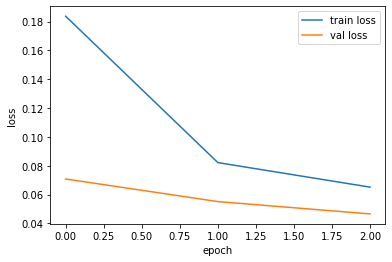

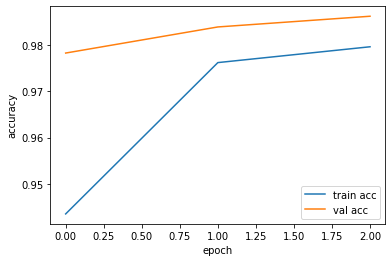

In [47]:
# # train the network
# print("[INFO] training model...")
histModel = model.fit(x_train_p, y_cat_train, validation_split=0.33, verbose=1,epochs=3)
print(histModel)

upr.PlotModelHistoryEpoch(histModel)
model.save('MNIST_model1_ep5.h5')

563/563 [==============================] - 2s 3ms/step - loss: 0.0456 - accuracy: 0.9866
Evaluate model on test data:  [0.04562404379248619, 0.9866111278533936]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification_report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99      1805
           1       0.99      0.99      0.99      2072
           2       0.99      0.98      0.99      1746
           3       1.00      0.98      0.99      1869
           4       0.99      0.99      0.99      1740
           5       0.99      0.99      0.99      1645
           6       0.98      0.99      0.99      1836
           7       0.97      1.00      0.98      1841
           8       0.99      0.98      0.98      1739
           9       1.00      0.96      0.98      1707

    accuracy                           0.99     18000
   macro avg       0.99      0.99      0.99     18000
weighted avg       0.99      0.99      0.99     18000

Confusion matrix, without normalization


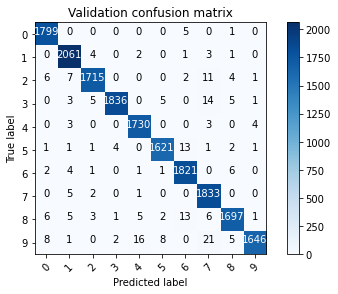

Set date/imagini eronate:  (241, 28, 28)


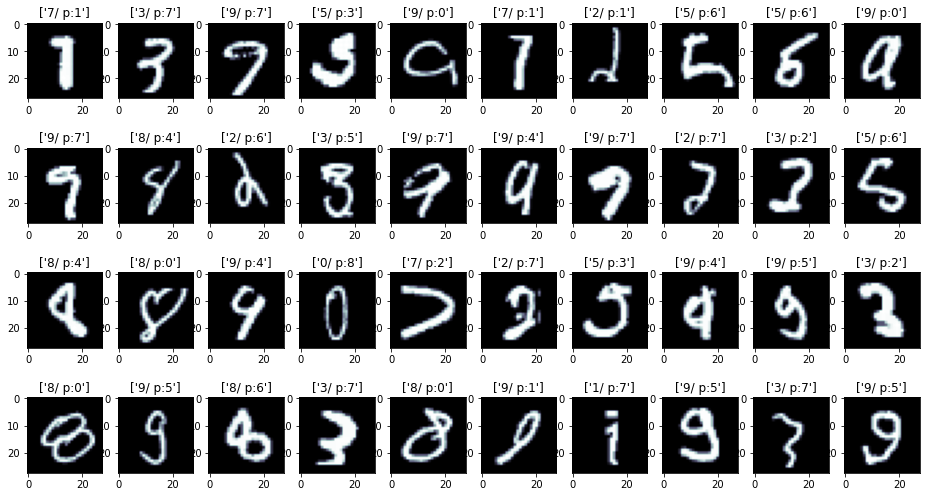

In [48]:
from sklearn import metrics
print("Evaluate model on test data: ", model.evaluate(x_test_p,y_cat_test))
predictions = model.predict_classes(x_test_p)
print("Classification_report: ",metrics.classification_report(y_test,predictions))
cm = metrics.confusion_matrix(y_test,predictions)
upr.ImagePlotConfusionMatrix(cm,y_label_names,  title='Validation confusion matrix')
if (x_test.shape[3] == 1): # imagini pe nivele de gri
  upr.ImageIllustrationPredictionResults(x_test[:,:,:,0], y_test, predictions, y_label_names)
else:
  upr.ImageIllustrationPredictionResults(x_test, y_test, predictions, y_label_names)


Prezentarea poate fi organizata considerand urmatoarea structura:
-	Prezentarea temei de rezolvat: 1 slide
-	Descriere pe scurt parte teoretica clasificator ~ 2 slide-uri
-	Descriere baza de date utilizata – numarul de date, dimensiune vector de trasaturi, descriere
-	Modalitatea de imartire in setul de antrenare/ test – 1 slide
o	Incercam 3 strategii pentru test_size: 0.3; 0.5, 0.7 (cei care au CNN nu pot modifica, se incarca direct divizat setul de date – deci nu trebuie)
-	Modalitati de preprocesare date (daca este cazul)
-	Modalitate de aplicare - antrenare in python (definire model, antrenare) – 1 slide
o	Modificare parametrii clasificator (daca se poate)
o	La CNN - modificare numar epoci (5, 10 sau 20)
-	Modalitate de aplicare - testare in python – 1 slide 
-	Evaluare model, si extragerea unor metrici de evaluare (Accuracy, Prediction, Re-call, Confusion Matrix) – interpretarea acestor valori 
-	Rezultate experimentale 
-	Concluzii
-	Observatii – pe ce ati fi dorit sa se puna acentul la acest algoritm in ora de laborator?